# Setting & Scraping the Data

## Collecting movies since 1990

In [ ]:
def get_movies_since(year):
    import pandas as pd
    year_data = pd.read_csv('year.csv', on_bad_lines='skip', sep="\t")
    movie_data = year_data[year_data["titleType"].isin(["movie", "tvMovie"])]
    movie_data_with_year = movie_data[movie_data["startYear"] >= "1990"]
    movie_data_with_valid_year = movie_data_with_year[movie_data_with_year["startYear"] != "\\N"]
    movie_data_with_valid_year = movie_data_with_valid_year[["tconst", "startYear", "originalTitle"]]

    imdb_data = pd.read_csv("ratings.csv", sep="\t")

    year_vote_data = pd.merge(imdb_data, movie_data_with_valid_year, on="tconst", how="right")
    year_vote_data = year_vote_data[["tconst","startYear","averageRating","numVotes", "originalTitle"]]
    year_vote_data.columns = ["title id","Year","Rating","Votes", "Title"]
    year_vote_data["rating link"] = "https://www.imdb.com/title/"+year_vote_data["title id"]+"/ratings/?ref_=tt_ov_rt"
    year_vote_data = year_vote_data.sort_values(by="title id").reset_index(drop=True)
    year_vote_data.to_csv("movies_since_"+"1990"+".csv", index=False)

    return year_vote_data
dataset = get_movies_since("1990")

## extracting vote data

In [26]:
def get_votes(link, vote_threshold=10000):
    import requests, re
    request_text = requests.get(link).text
    if "No Ratings Available" in request_text or "Well, what if there is no webpage?" in request_text or int(((request_text[request_text.index("IMDb users have given a ")-15:request_text.index("IMDb users have given a ")-1].strip()).replace(",",""))) < vote_threshold:
        return [0,0,0,0,0,0,0,0,0,0], 0.0

    star_votes = re.findall("<div class=\"leftAligned\">(.*?)</div>", request_text)
    rating = re.findall("span class=\"ipl-rating-star__rating\">(.*?)</span>", request_text)
    stars = [int(vote.replace(",","")) for vote in star_votes[1:11]]
    
    return stars, float(rating[0])

In [4]:
# 1 second for a link
stars, rating = get_votes("https://www.imdb.com/title/tt0068646/ratings/?ref_=tt_ov_rt", vote_threshold=10000)

In [38]:
def fill_dataset(dataset, start=0, end=0, zip=1):
    for i in range(start, end):
        try:
            stars, rating = get_votes(dataset.iloc[i]["rating link"])
            dataset.loc[i,["1","2","3","4","5","6","7","8","9","10"]] = stars
            dataset.loc[i,["Rating","Votes"]] = rating, sum(stars)
        except:
            pass
        if i % 100 == 0:
            print(i,". movie done between ",start,"-",end, sep="")

    if zip:
        print(end,". movie done between ",start,"-",end, sep="")
        dataset[:end].to_csv("movie_data_at_"+str(start)+"_"+str(end)+".csv", index=False)
    return dataset

In [ ]:
import pandas as pd
dataset = pd.read_csv("movie_data_at_5000_6000.csv")
dataset = fill_dataset(dataset, start=6000, end=7000, zip=1)

## Merging movie and box office datasets

In [1]:
def merge_movies_with_boxoffices(movie_csv_path, how_to_merge):
    import pandas as pd
    dataset = pd.read_csv(movie_csv_path)
    dataset = dataset[~dataset["1"].isnull()]
    dataset = dataset[dataset["Votes"]>0]
    dataset["Title-Year"] = dataset["Year"].astype(str) + " " + dataset["Title"]

    movie_box_dataset = pd.read_csv("year_movie_worldwide_box.csv")
    movie_box_dataset.columns =  ["Year", "Title", "WorldwideBox Office"]
    movie_box_dataset["Title-Year"] = movie_box_dataset["Year"].astype(int).astype(str) + " " + movie_box_dataset["Title"]

    including_movies = movie_box_dataset[movie_box_dataset["Title-Year"].isin(list(dataset["Title-Year"]))]
    merge = pd.merge(dataset, including_movies[["Title-Year","WorldwideBox Office"]], on="Title-Year", how=how_to_merge)
    return merge

In [ ]:
merge = merge_movies_with_boxoffices("informative_movie_data.csv", "outer")
merge.head(3)

## Getting revenues

In [ ]:
def get_revenue(link):
    import requests
    text = requests.get(link).text
    if "<span class=\"ipc-metadata-list-item__label\">Gross worldwide</span>" in text:
        revenue_part = text[text.index("<span class=\"ipc-metadata-list-item__label\">Gross worldwide</span>"):]
        revenue = int(revenue_part[revenue_part.index("$")+1:].split("</span>")[0].replace(",",""))
        return revenue
    raise Exception("cant find worldwide gross")

In [ ]:
def fill_revenues(dataset, start=0, end=0, zip=1):
    from datetime import datetime

    for i in range(start, end):
        try:
            revenue = get_revenue(dataset.iloc[i]["imdb_url"])
            dataset.loc[i,"WorldwideBox Office"] = revenue
        except:
            pass
        if i % 100 == 0:
            print(datetime.now().strftime("%H:%M:%S"), " ..... ", i,". movie done between ",start,"-",end, sep="")
            if i%1000 == 0 and zip:
                dataset[:end].to_csv("movie_revenue_data_at_"+str(start)+"_"+str(end)+".csv", index=False)

    dataset.to_csv("movie_revenue_data_all.csv", index=False)
    return dataset

In [ ]:
def get_revenue_from_wikipedia(title_year):
    import requests
    year, title = title_year[:title_year.index(" ")], title_year[title_year.index(" ")+1:]

    try:
        text = requests.get("https://en.wikipedia.org/wiki/"+title.replace(" ","_")).text
        a = text[text.index("Box office</th>"):]
        revenue = a[a.index("style=\"white-space: nowrap\">") + len("style=\"white-space: nowrap\">"): a.index("</span>")]
        return revenue
    except:
        pass
    try:
        text_film = requests.get("https://en.wikipedia.org/wiki/"+title.replace(" ","_")+"_(film)").text
        a = text_film[text_film.index("Box office</th>"):]
        revenue = a[a.index("style=\"white-space: nowrap\">") + len("style=\"white-space: nowrap\">"): a.index("</span>")]
        return revenue
    except:
        pass
    try:
        text_film_year = requests.get("https://en.wikipedia.org/wiki/"+title.replace(" ","_")+"_("+year+"_film)").text
        a = text_film_year[text_film_year.index("Box office</th>"):]
        revenue = a[a.index("style=\"white-space: nowrap\">") + len("style=\"white-space: nowrap\">"): a.index("</span>")]
        return revenue
    except:
        pass
    raise Exception("cant find worldwide gross")

In [ ]:
def fill_revenues_from_wikipedia(dataset, indices, start=0, end=0, zip=1):
    from datetime import datetime

    for i in indices:
        try:
            revenue = get_revenue_from_wikipedia(dataset.iloc[i]["Title-Year"])
            dataset.loc[i,"WorldwideBox Office"] = revenue
        except:
            pass
        if i % 100 == 0:
            print(datetime.now().strftime("%H:%M:%S"), " ..... ", i,". movie done between ",start,"-",end, sep="")
            if i%1000 == 0 and zip:
                dataset[:end].to_csv("movie_revenue_data_at_"+str(start)+"_"+str(end)+".csv", index=False)

    dataset.to_csv("movie_revenue_data_all.csv", index=False)
    return dataset

# Exploring data

## Checking data

In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv("movie_revenue_data.csv")
data = pd.DataFrame(data)

In [2]:
data

,Title,Year,Rating,Votes,1,2,3,4,5,6,7,8,9,10,WorldwideBox Office
0,Kate & Leopold,2001,6.4,84837.0,5747.0,4409.0,11615.0,23031.0,21676.0,10417.0,4195.0,1840.0,934.0,973.0,76019048.0
1,3 Men and a Little Lady,1990,5.4,24975.0,1482.0,691.0,1698.0,3363.0,5619.0,5822.0,3195.0,1617.0,793.0,695.0,71609321.0
2,The Adventures of Ford Fairlane,1990,6.4,18338.0,3060.0,1462.0,2690.0,3255.0,2726.0,1723.0,1166.0,811.0,635.0,810.0,21413502.0
3,Air America,1990,5.8,28924.0,1195.0,663.0,2123.0,5338.0,8555.0,6295.0,2629.0,1110.0,489.0,527.0,33461269.0
4,Alice,1990,6.6,14431.0,722.0,781.0,2274.0,4450.0,3486.0,1447.0,547.0,242.0,154.0,328.0,7331647.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7522,Major,2022,8.2,26633.0,15787.0,3848.0,2983.0,1725.0,753.0,334.0,175.0,113.0,130.0,785.0,4961424.0
7523,Malang - Unleash the Madness,2020,6.5,10831.0,1801.0,862.0,1773.0,2425.0,1599.0,810.0,379.0,224.0,186.0,772.0,8399765.0
7524,I Care a Lot,2020,6.3,132399.0,5922.0,6346.0,19670.0,34795.0,25626.0,11858.0,6389.0,4521.0,3958.0,13314.0,1351662.0
7525,Kaithi,2019,8.5,31255.0,13638.0,7743.0,5705.0,2371.0,732.0,286.0,128.0,79.0,88.0,485.0,522938.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7527 entries, 0 to 7526
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Title                7527 non-null   object 
 1   Year                 7527 non-null   int64  
 2   Rating               7527 non-null   float64
 3   Votes                7527 non-null   float64
 4   1                    7527 non-null   float64
 5   2                    7527 non-null   float64
 6   3                    7527 non-null   float64
 7   4                    7527 non-null   float64
 8   5                    7527 non-null   float64
 9   6                    7527 non-null   float64
 10  7                    7527 non-null   float64
 11  8                    7527 non-null   float64
 12  9                    7527 non-null   float64
 13  10                   7527 non-null   float64
 14  WorldwideBox Office  7527 non-null   float64
dtypes: float64(13), int64(1), object(1)
me

In [4]:
data.describe()

,Year,Rating,Votes,1,2,3,4,5,6,7,8,9,10,WorldwideBox Office
count,7527.000000,7527.000000,7.527000e+03,7.527000e+03,7527.000000,7527.000000,7527.000000,7527.000000,7527.000000,7527.000000,7527.000000,7527.000000,7527.000000,7.527000e+03
mean,2008.128338,6.502949,9.852114e+04,1.221116e+04,12318.986449,21549.622957,22538.121828,14290.586954,7117.162880,3330.487977,1828.450910,1174.572207,2161.988707,7.866690e+07
std,8.286445,1.012327,1.736260e+05,4.340549e+04,40805.113220,46649.586549,34272.388366,18223.531560,8744.337904,4254.185511,2495.289187,1724.667779,4580.929819,1.690744e+08
min,1990.000000,1.000000,1.000200e+04,1.840000e+02,44.000000,23.000000,10.000000,7.000000,9.000000,6.000000,6.000000,13.000000,63.000000,5.800000e+01
25%,2002.000000,5.900000,1.805550e+04,1.434500e+03,1007.000000,2438.000000,3650.000000,2938.500000,1611.500000,702.000000,369.000000,240.000000,443.500000,3.312487e+06
50%,2009.000000,6.600000,3.798900e+04,3.186000e+03,2458.000000,5604.000000,8122.000000,6583.000000,3641.000000,1739.000000,926.000000,577.000000,936.000000,1.942817e+07
75%,2015.000000,7.200000,1.003410e+05,8.554500e+03,7450.500000,17266.000000,24688.500000,18410.500000,9244.000000,4240.000000,2289.500000,1408.500000,2177.000000,7.634441e+07
max,2022.000000,9.300000,2.649698e+06,1.459201e+06,739235.000000,484021.000000,282367.000000,165290.000000,96503.000000,55952.000000,41242.000000,34882.000000,140664.000000,2.923899e+09


In [5]:
data.isnull().sum().sum()

0

## Visualization

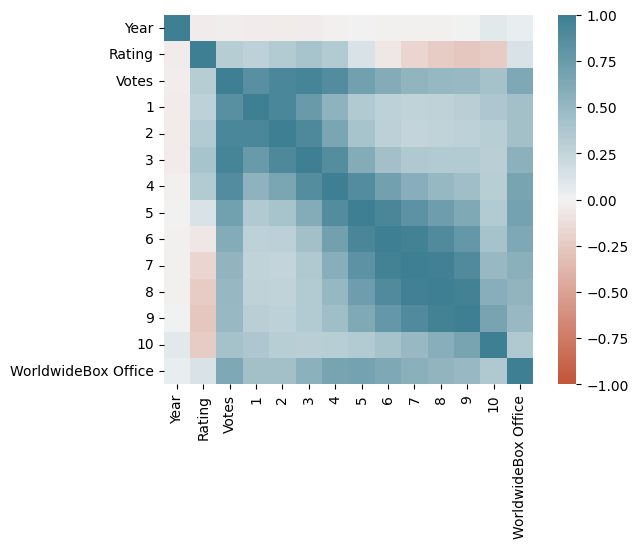

In [6]:
import seaborn as sns
ax = sns.heatmap(
    data[data.columns[1:]].corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

<AxesSubplot: >

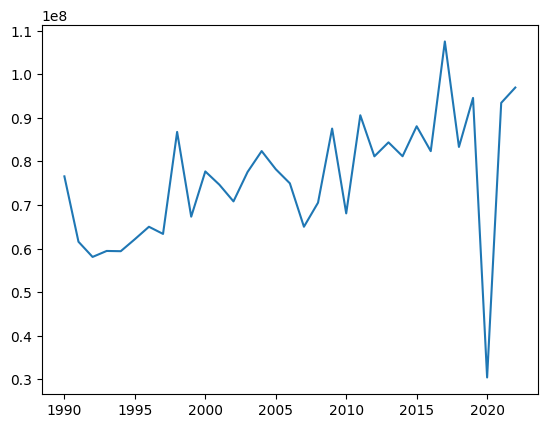

In [7]:
years = (data["Year"]).unique()
years.sort()
revenues = []
for year in (data["Year"]).unique():
    revenues.append(data[data["Year"] == year]["WorldwideBox Office"].mean())
sns.lineplot(x=years, y=revenues)

In [8]:
scaled_revenues = np.array(revenues)/1e8
year_revenue_dict = {years[i]: scaled_revenues[i] for i in range(len(years))}
data['Year'] = data['Year'].map(year_revenue_dict)

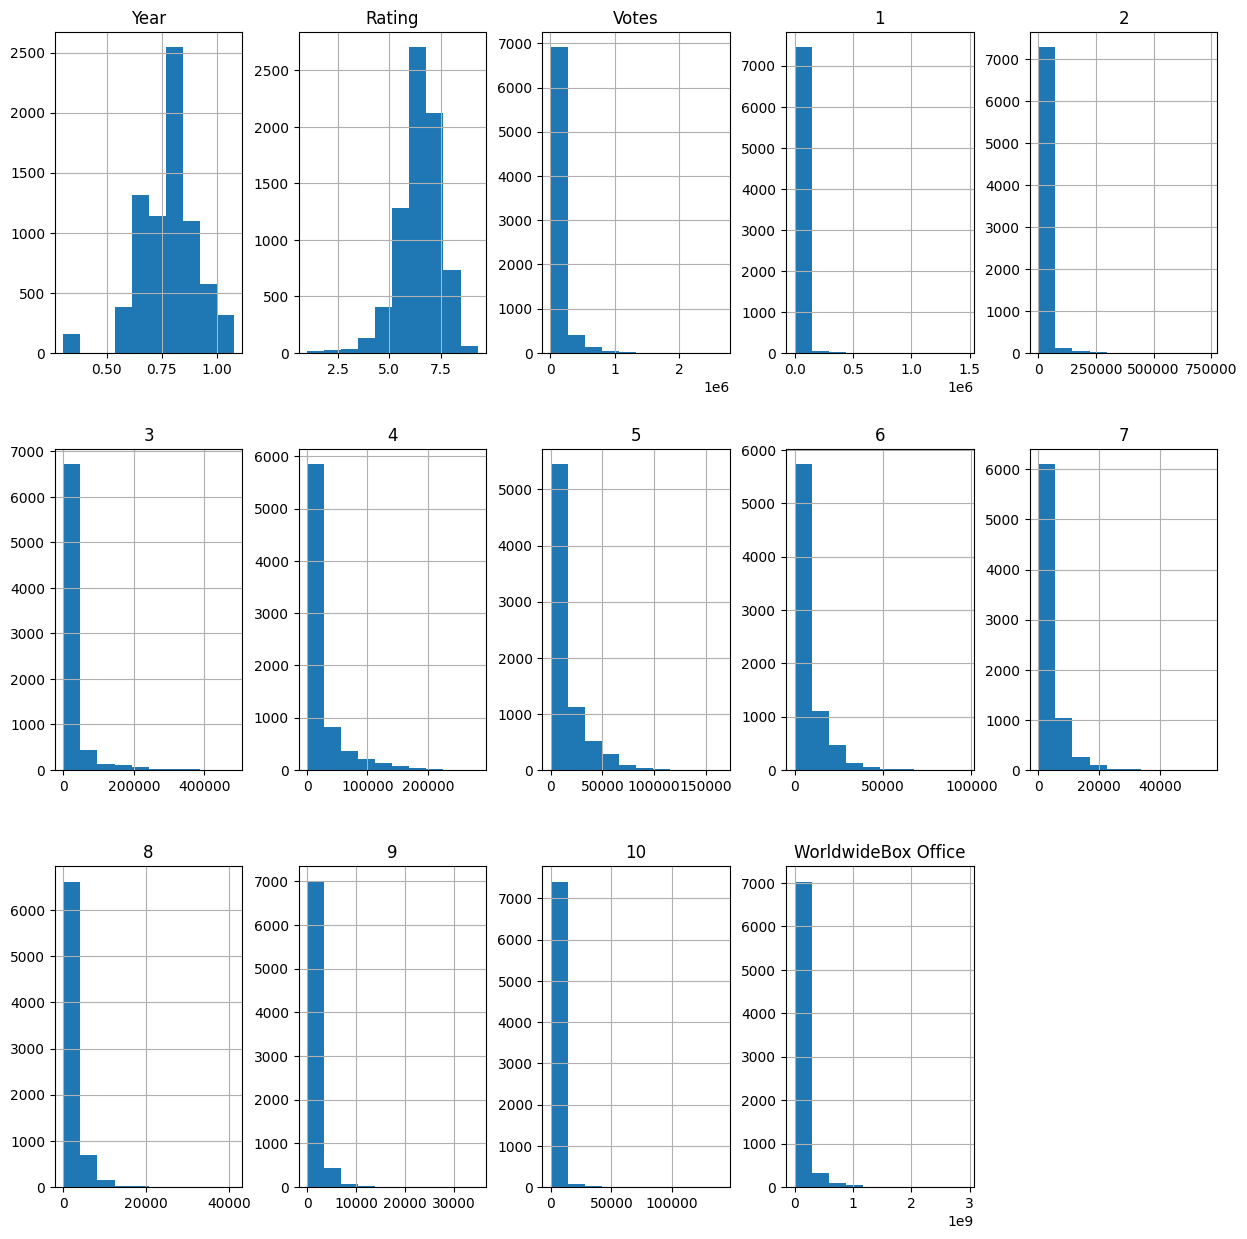

In [9]:
data[data.columns[1:]].hist(layout=(3,5), figsize=(15,15));

## splitting and normalization

AFTER NORMALIZATIONS


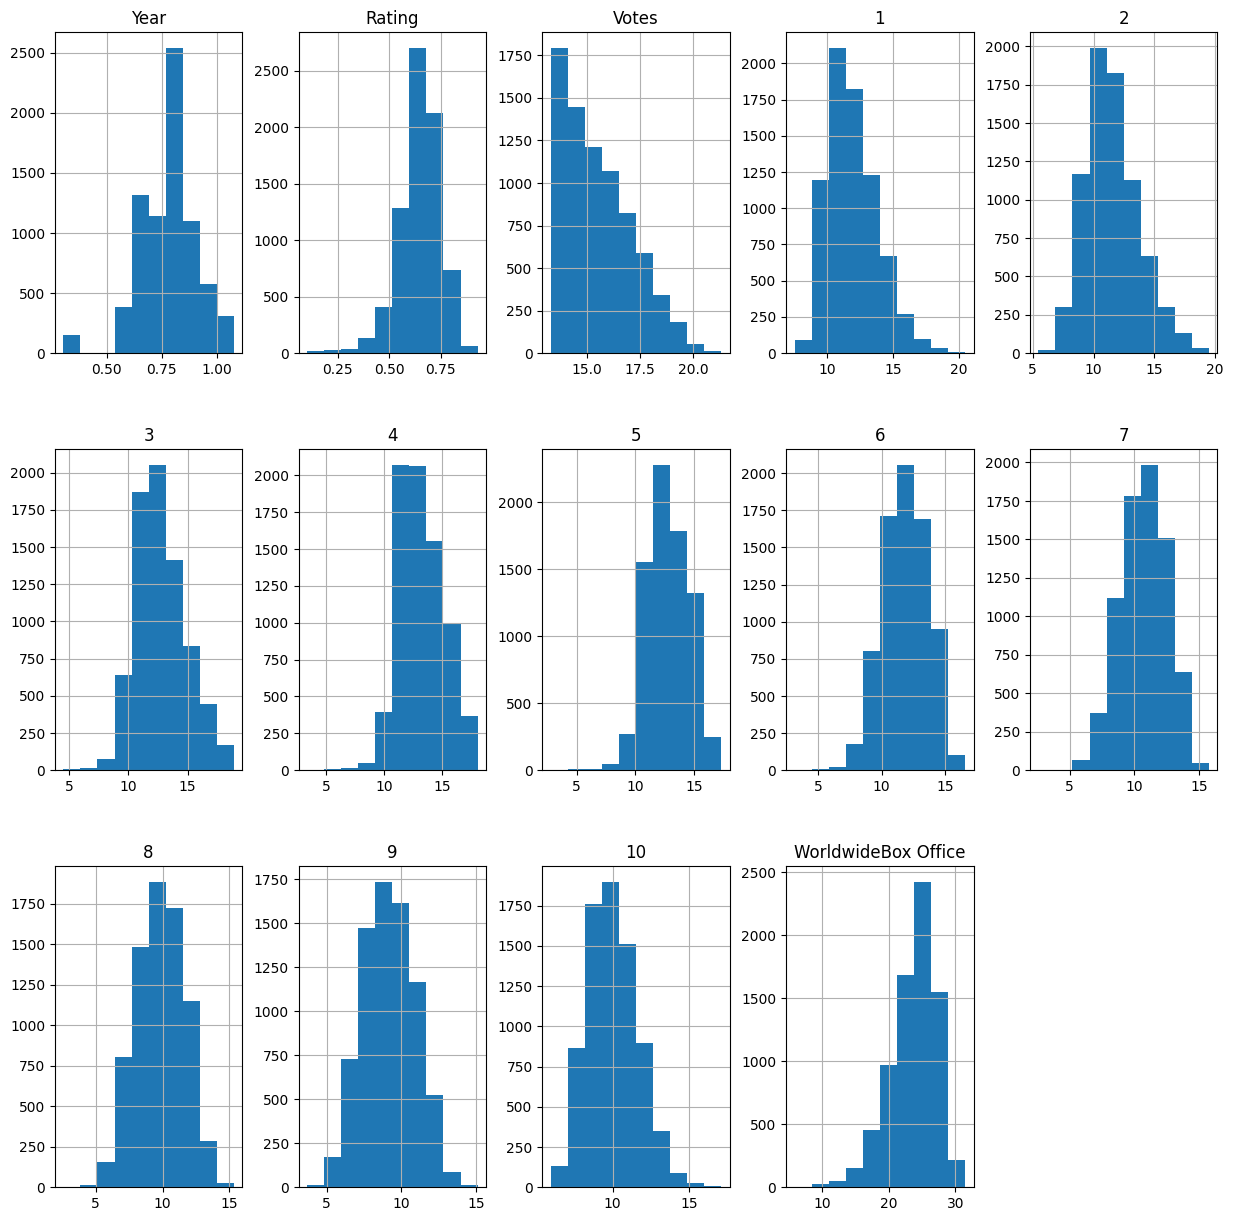

In [10]:
data["Rating"] = data["Rating"]/10
data[['Votes', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'WorldwideBox Office']] = np.log2(data[['Votes', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'WorldwideBox Office']])
print("AFTER NORMALIZATIONS")
data[data.columns[1:]].hist(layout=(3,5), figsize=(15,15));

<AxesSubplot: xlabel='WorldwideBox Office', ylabel='Count'>

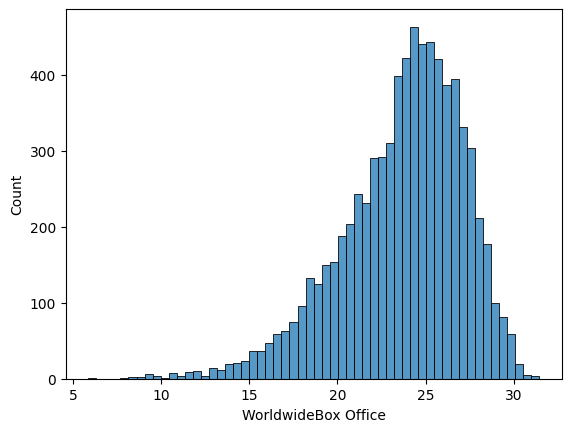

In [11]:
sns.histplot(data=data, x="WorldwideBox Office")

In [12]:
data=data[data["WorldwideBox Office"]>15].reset_index(drop=True)

<AxesSubplot: xlabel='WorldwideBox Office', ylabel='Count'>

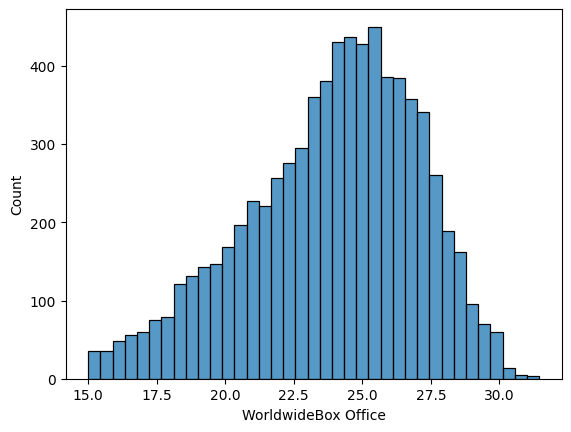

In [13]:
sns.histplot(data=data, x="WorldwideBox Office")

In [14]:
import math 
SEED = int(math.sqrt(201401004 + 191401009))

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Title','WorldwideBox Office'], axis=1), data['WorldwideBox Office'], test_size=0.10, random_state=SEED)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.1111111111111111, random_state=SEED)

In [16]:
from pickle import dump
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
X_train[['Votes', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']]= min_max_scaler.fit_transform(X_train[['Votes', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']])
X_validation[['Votes', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']]= min_max_scaler.transform(X_validation[['Votes', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']])
X_test[['Votes', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']]= min_max_scaler.transform(X_test[['Votes', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']])

dump(min_max_scaler, open('MinMaxScaler.pickle', 'wb'))

In [17]:
print("train percentage:", round(len(X_train)/len(data)*100),"%", sep="")
print("test percentage:", round(len(X_test)/len(data)*100),"%", sep="")
print("validation percentage:", round(len(X_validation)/len(data)*100),"%", sep="")

train percentage:80%
test percentage:10%
validation percentage:10%


X_train AFTER ALL NORMALIZATIONS


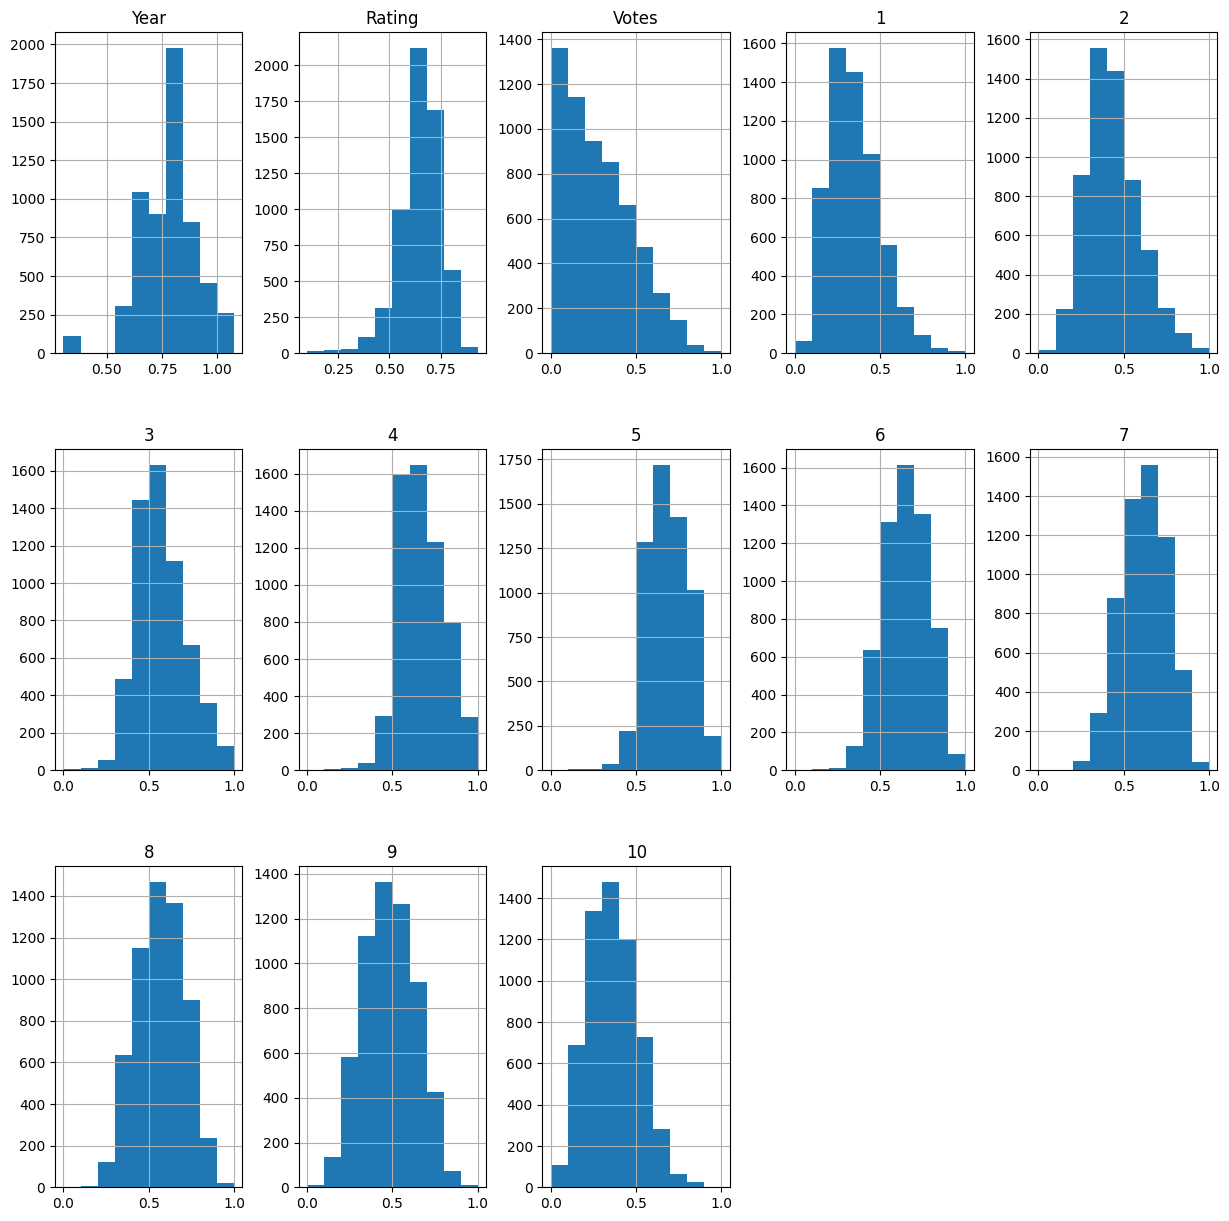

In [18]:
print("X_train AFTER ALL NORMALIZATIONS")
X_train[X_train.columns].hist(layout=(3,5), figsize=(15,15));

"Year" column'unu nasıl kullanalım?

column'lar "log2" ile normalize edildikten sonra 0-1 arasına da çekelim mi? bence mantıklı

In [1]:
def set_data():
    import pandas as pd
    import numpy as np
    data = pd.read_csv("movie_revenue_data.csv")
    data = pd.DataFrame(data)

    years = (data["Year"]).unique()
    years.sort()
    revenues = []
    for year in (data["Year"]).unique():
        revenues.append(data[data["Year"] == year]["WorldwideBox Office"].mean())

    scaled_revenues = np.array(revenues)/1e8
    year_revenue_dict = {years[i]: scaled_revenues[i] for i in range(len(years))}
    data['Year'] = data['Year'].map(year_revenue_dict)
    data["Rating"] = data["Rating"]/10
    data[['Votes', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'WorldwideBox Office']] = np.log2(data[['Votes', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'WorldwideBox Office']])
    data = data[data["WorldwideBox Office"]>13]

    import math 
    SEED = int(math.sqrt(201401004 + 191401009))

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(data.drop(['Title','WorldwideBox Office'], axis=1), data['WorldwideBox Office'], test_size=0.10, random_state=SEED)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.1111111111111111, random_state=SEED)

    from pickle import dump
    from sklearn import preprocessing
    min_max_scaler = preprocessing.MinMaxScaler()
    X_train[['Votes', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']]= min_max_scaler.fit_transform(X_train[['Votes', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']])
    X_validation[['Votes', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']]= min_max_scaler.transform(X_validation[['Votes', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']])
    X_test[['Votes', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']]= min_max_scaler.transform(X_test[['Votes', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']])
    dump(min_max_scaler, open('MinMaxScaler.pickle', 'wb'))

    return data, X_train, X_validation, X_test, y_train, y_validation, y_test

import math 
SEED = int(math.sqrt(201401004 + 191401009))
data, X_train, X_validation, X_test, y_train, y_validation, y_test = set_data()

# Models

## Linear regression

In [2]:
try:
    import pickle
    LR = pickle.load(open('LR.pickle', 'rb'))
except:
    from sklearn.linear_model import LinearRegression
    LR = LinearRegression().fit(X_train, y_train)
    import pickle
    pickle.dump(LR, open('LR.pickle', 'wb'))

print("LinearRegression score on train:", LR.score(X_train, y_train))

LinearRegression score on train: 0.5016969409967591


In [3]:
LR_validation_prediction = LR.predict(X_validation)

from sklearn.metrics import mean_squared_error
print("Linear Regression mean squared error on validation:", mean_squared_error(y_validation, LR_validation_prediction, squared=True))

from sklearn.metrics import mean_squared_error
print("Linear Regression root mean squared error on validation:", mean_squared_error(y_validation, LR_validation_prediction ,squared=False))

from sklearn.metrics import mean_absolute_error
print("Linear Regression mean absolute error on validation:", mean_absolute_error(y_validation, LR_validation_prediction))

from sklearn.metrics import r2_score
print("Linear Regression r2 score on validation:", r2_score(y_validation, LR_validation_prediction))

#Adjusted R Squared:
print("Linear Regression adjusted r2 score on validation:", 1-(1-r2_score(y_validation, LR_validation_prediction))*((len(y_validation))-1)/((len(y_validation))-len(X_validation.columns)))

Linear Regression mean squared error on validation: 5.631171312503155
Linear Regression root mean squared error on validation: 2.3730089153863614
Linear Regression mean absolute error on validation: 1.776084480548773
Linear Regression r2 score on validation: 0.49199070717023496
Linear Regression adjusted r2 score on validation: 0.4836853781321462


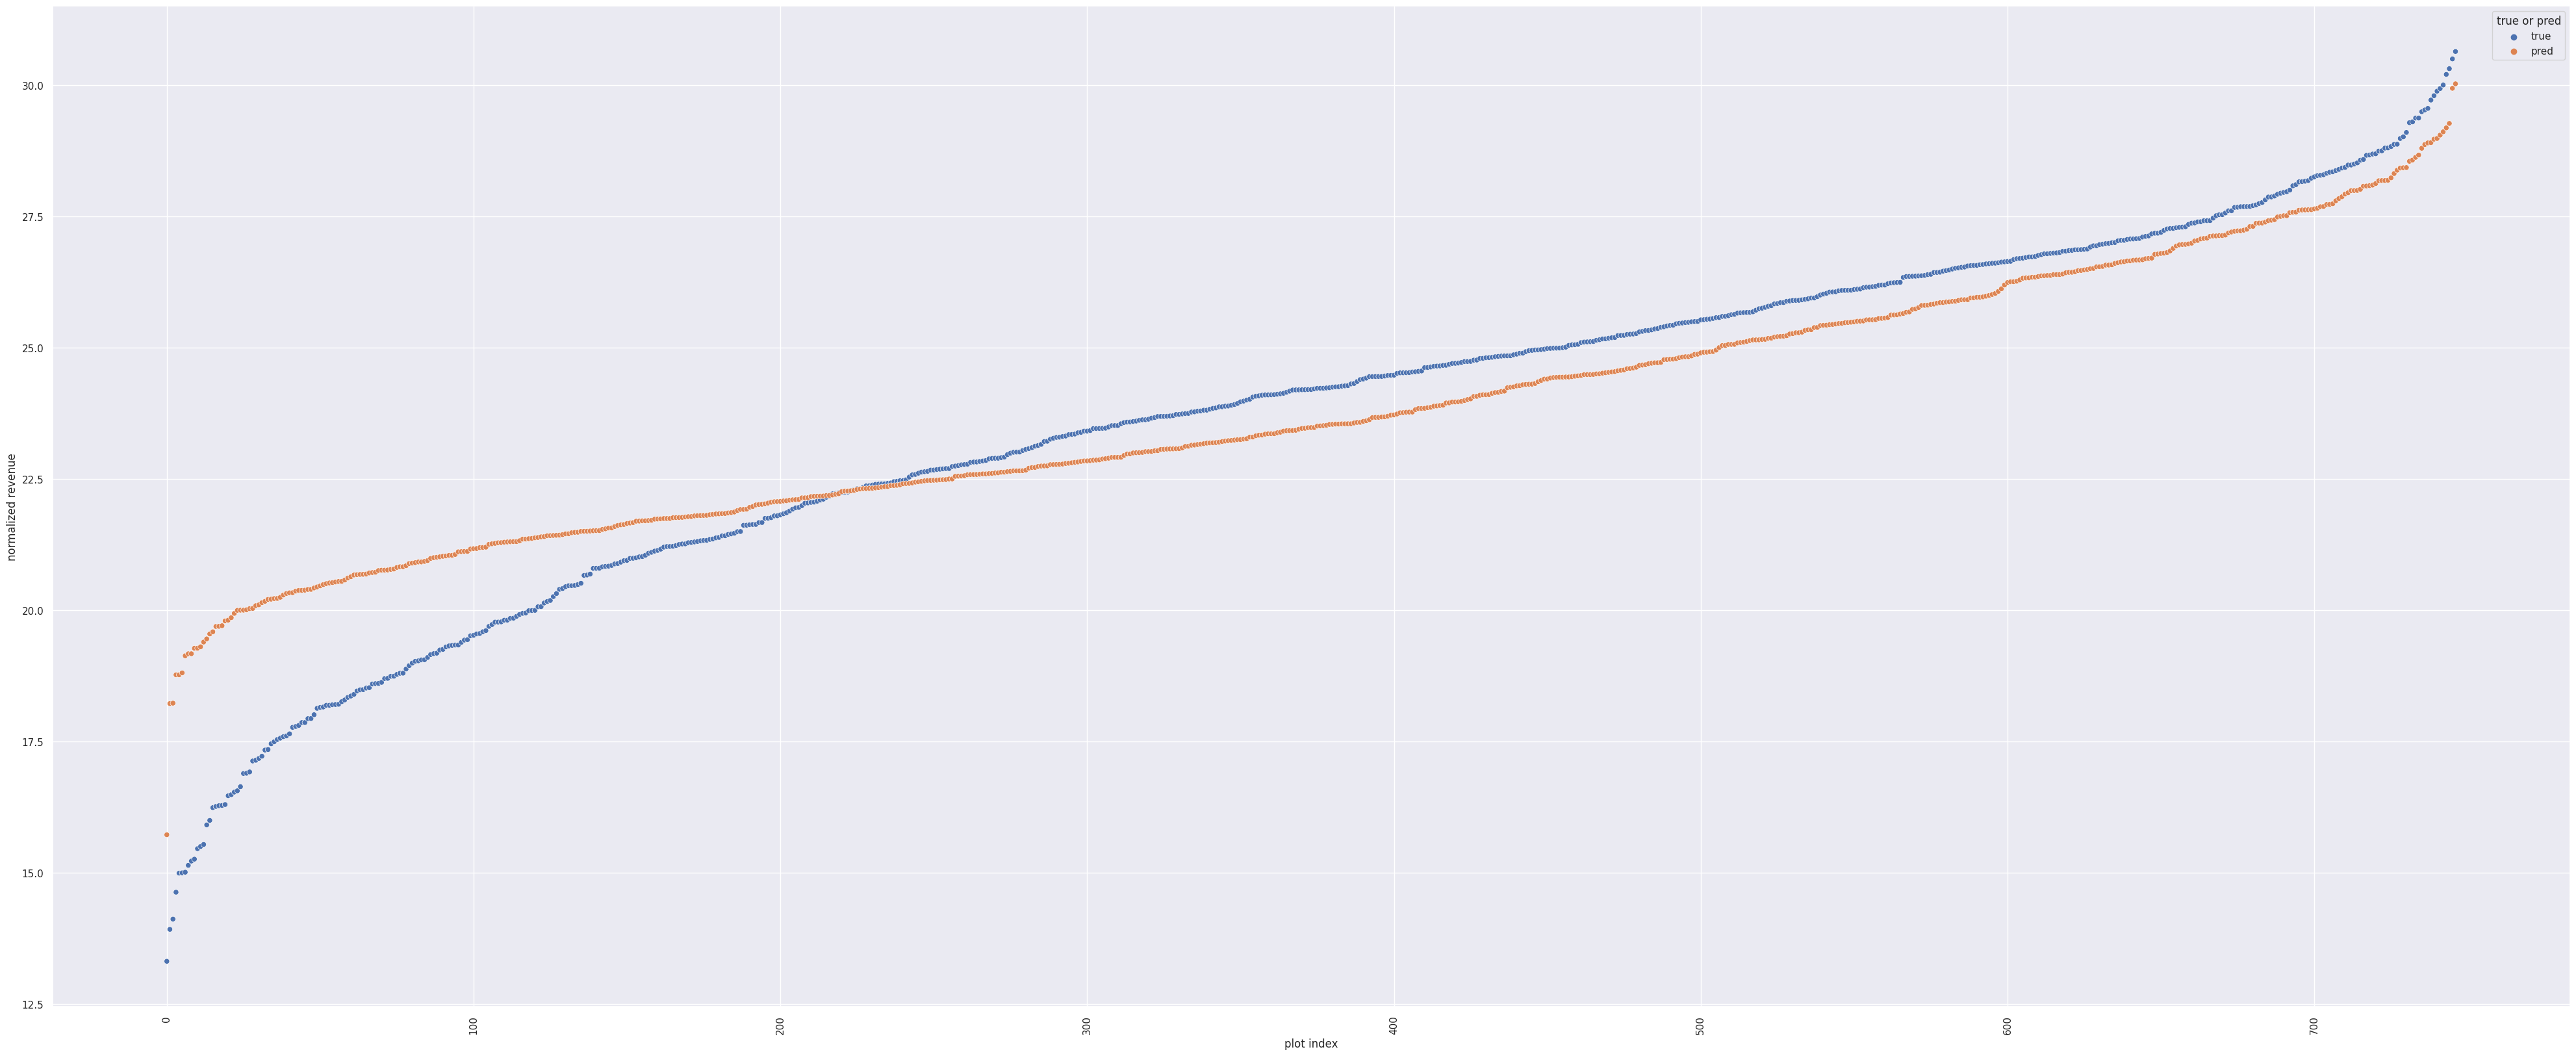

In [4]:
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import numpy as np

LR_pred_data = pd.DataFrame({'normalized revenue': np.hstack((y_validation, LR_validation_prediction)), 'true or pred': np.hstack((["true"]*len(y_validation) , ["pred"]*len(LR_validation_prediction)))})
LR_pred_data.sort_values(by=['normalized revenue'], ascending = True, inplace = True)
LR_pred_data_T = LR_pred_data[LR_pred_data["true or pred"] == "true"]
LR_pred_data_T.insert(0, "plot index", list(range(len(y_validation))))
LR_pred_data_P = LR_pred_data[LR_pred_data["true or pred"] == "pred"]
LR_pred_data_P.insert(0, "plot index", list(range(len(y_validation))))
LR_plot_data = pd.concat([LR_pred_data_T, LR_pred_data_P])

sns.set(rc={'figure.figsize':(50,20)})
sns.scatterplot(data=LR_plot_data,
                x="plot index",
                y="normalized revenue",
                hue="true or pred")
plt.xticks(rotation=90);

In [1]:
# histogram of true-prediction cases
# histogram of true-prediction cases
# histogram of true-prediction cases

## Support vector regression

In [2]:
try:
    import pickle
    SVR_grid = pickle.load(open('SVR_grid.pickle', 'rb'))
    print("tuned hpyerparameters :(best parameters) ", SVR_grid.best_params_)
    print("Support Vector Machine score on train:", SVR_grid.best_score_)
    SVR_best = SVR_grid.best_estimator_
except:
    import warnings
    warnings.filterwarnings("ignore")
    from sklearn.model_selection import GridSearchCV
    from sklearn.svm import SVR
    grid = {
            'C': [0.1, 1, 10, 100],
            "kernel": ['poly', 'rbf'],
            "gamma": [0.1, 1, 5, 10],
            "degree": [2, 3, 4],
            "max_iter": [4000, 5000, 6000]
            }
    SVR = SVR()
    SVR_grid = GridSearchCV(SVR, grid, refit = True, n_jobs=-1, cv=10)
    SVR_grid.fit(X_train, y_train)
    print("tuned hpyerparameters :(best parameters) ", SVR_grid.best_params_)
    print("Support Vector Machine score on train:", SVR_grid.best_score_)
    SVR_best = SVR_grid.best_estimator_

    import pickle
    pickle.dump(SVR_grid, open('SVR_grid.pickle', 'wb'))

KeyboardInterrupt: 

In [6]:
SVR_best_validation_prediction = SVR_best.predict(X_validation)

from sklearn.metrics import mean_squared_error
print("SVR mean squared error on validation:", mean_squared_error(y_validation, SVR_best_validation_prediction, squared=True))

from sklearn.metrics import mean_squared_error
print("SVR root mean squared error on validation:", mean_squared_error(y_validation, SVR_best_validation_prediction ,squared=False))

from sklearn.metrics import mean_absolute_error
print("SVR mean absolute error on validation:", mean_absolute_error(y_validation, SVR_best_validation_prediction))

from sklearn.metrics import r2_score
print("SVR r2 score on validation:", r2_score(y_validation, SVR_best_validation_prediction))

#Adjusted R Squared:
print("SVR adjusted r2 score on validation:", 1-(1-r2_score(y_validation, SVR_best_validation_prediction))*((len(y_validation))-1)/((len(y_validation))-len(X_validation.columns)))

SVR mean squared error on validation: 4.9246675625157375
SVR root mean squared error on validation: 2.2191592017058483
SVR mean absolute error on validation: 1.603946338292906
SVR r2 score on validation: 0.5557270864233006
SVR adjusted r2 score on validation: 0.5484637690351257


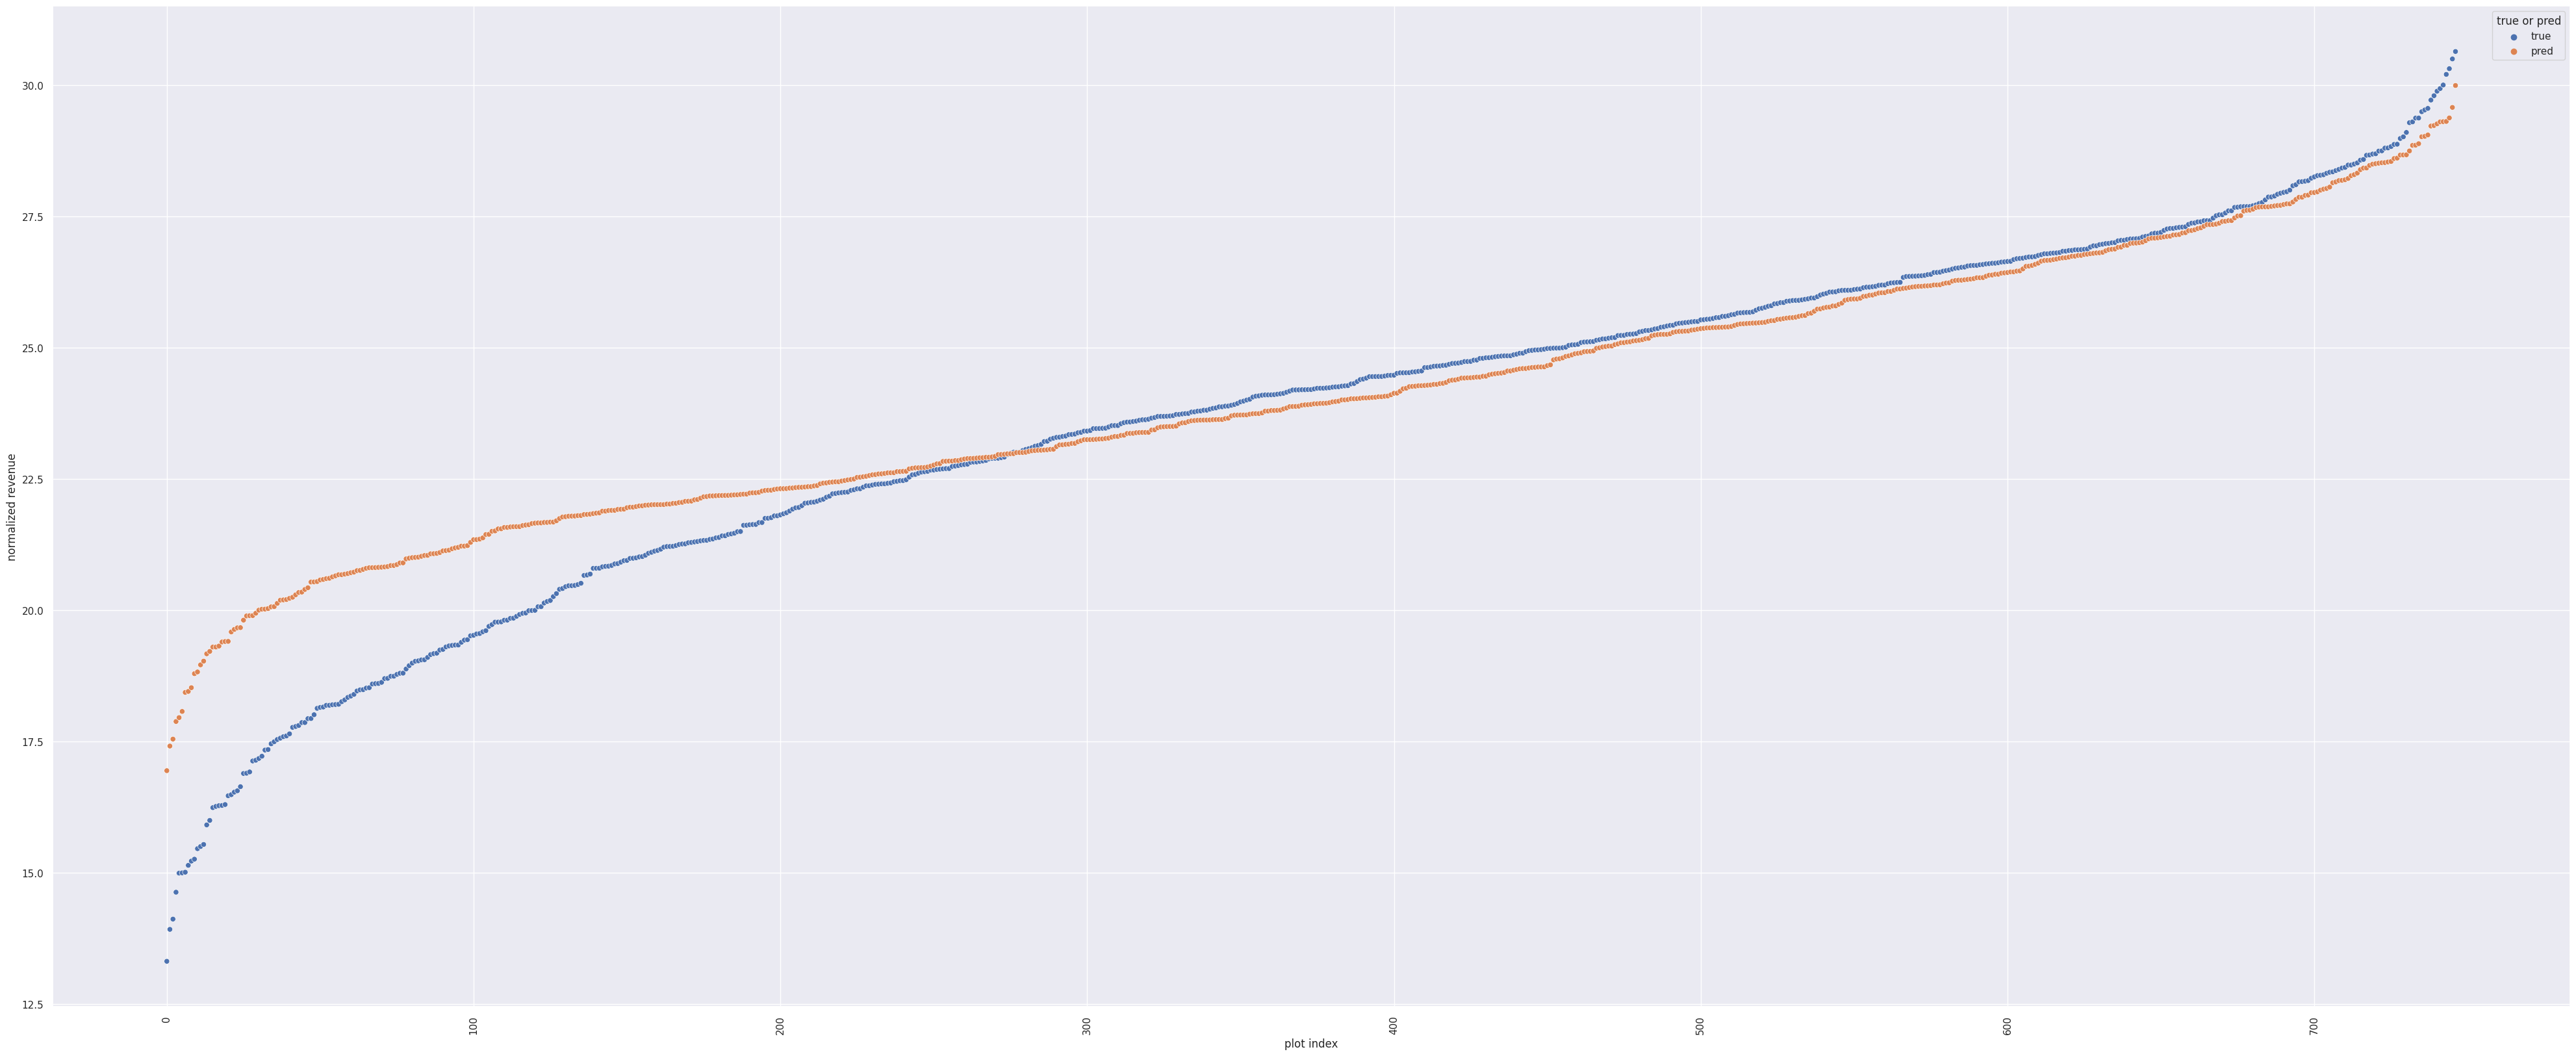

In [7]:
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import numpy as np

SVR_pred_data = pd.DataFrame({'normalized revenue': np.hstack((y_validation, SVR_best_validation_prediction)), 'true or pred': np.hstack((["true"]*len(y_validation) , ["pred"]*len(SVR_best_validation_prediction)))})
SVR_pred_data.sort_values(by=['normalized revenue'], ascending = True, inplace = True)
SVR_pred_data_T = SVR_pred_data[SVR_pred_data["true or pred"] == "true"]
SVR_pred_data_T.insert(0, "plot index", list(range(len(y_validation))))
SVR_pred_data_P = SVR_pred_data[SVR_pred_data["true or pred"] == "pred"]
SVR_pred_data_P.insert(0, "plot index", list(range(len(y_validation))))
SVR_plot_data = pd.concat([SVR_pred_data_T, SVR_pred_data_P])

sns.set(rc={'figure.figsize':(50,20)})
sns.scatterplot(data=SVR_plot_data,
                x="plot index",
                y="normalized revenue",
                hue="true or pred")
plt.xticks(rotation=90);

## random forest regression

In [8]:
try:
    import pickle
    RFR_grid = pickle.load(open('RFR_grid.pickle', 'rb'))
    print("tuned hpyerparameters :(best parameters) ", RFR_grid.best_params_)
    print("RandomForestRegressor score on train:", RFR_grid.best_score_)
    RFR_best = RFR_grid.best_estimator_
except:
    import warnings
    warnings.filterwarnings("ignore")
    from sklearn.model_selection import GridSearchCV
    from sklearn.ensemble import RandomForestRegressor
    
    grid = {
            "n_estimators": [300, 400, 500],
            'max_depth': [10, 15, 20],
            "criterion": ['squared_error', 'absolute_error'],
            "max_samples": [0.5, 0.75,  1],
            "min_samples_split": [2, 4, 6],
            "max_features": [1, 3, 5, 7],
            }

    RFR = RandomForestRegressor(random_state=SEED, bootstrap=True, oob_score=True, n_jobs=-1)

    RFR_grid = GridSearchCV(RFR, grid, refit = True, n_jobs=-1, cv=10)
    RFR_grid.fit(X_train, y_train)
    print("tuned hpyerparameters :(best parameters) ", RFR_grid.best_params_)
    print("RandomForestRegressor score on train:", RFR_grid.best_score_)
    RFR_best = RFR_grid.best_estimator_
    
    import pickle
    pickle.dump(RFR_grid, open('RFR_grid.pickle', 'wb'))


tuned hpyerparameters :(best parameters)  {'criterion': 'absolute_error', 'max_depth': 20, 'max_features': 7, 'max_samples': 0.75, 'min_samples_split': 6, 'n_estimators': 400}
RandomForestRegressor score on train: 0.5390713295175195


In [9]:
RFR_best_validation_prediction = RFR_best.predict(X_validation)

from sklearn.metrics import mean_squared_error
print("RFR mean squared error on validation:", mean_squared_error(y_validation, RFR_best_validation_prediction, squared=True))

from sklearn.metrics import mean_squared_error
print("RFR root mean squared error on validation:", mean_squared_error(y_validation, RFR_best_validation_prediction ,squared=False))

from sklearn.metrics import mean_absolute_error
print("RFR mean absolute error on validation:", mean_absolute_error(y_validation, RFR_best_validation_prediction))

from sklearn.metrics import r2_score
print("RFR r2 score on validation:", r2_score(y_validation, RFR_best_validation_prediction))

#Adjusted R Squared:
print("RFR adjusted r2 score on validation:", 1-(1-r2_score(y_validation, RFR_best_validation_prediction))*((len(y_validation))-1)/((len(y_validation))-len(X_validation.columns)))

RFR mean squared error on validation: 4.956502102958408
RFR root mean squared error on validation: 2.2263203055621643
RFR mean absolute error on validation: 1.685131857190781
RFR r2 score on validation: 0.5528551719528718
RFR adjusted r2 score on validation: 0.5455449022845265


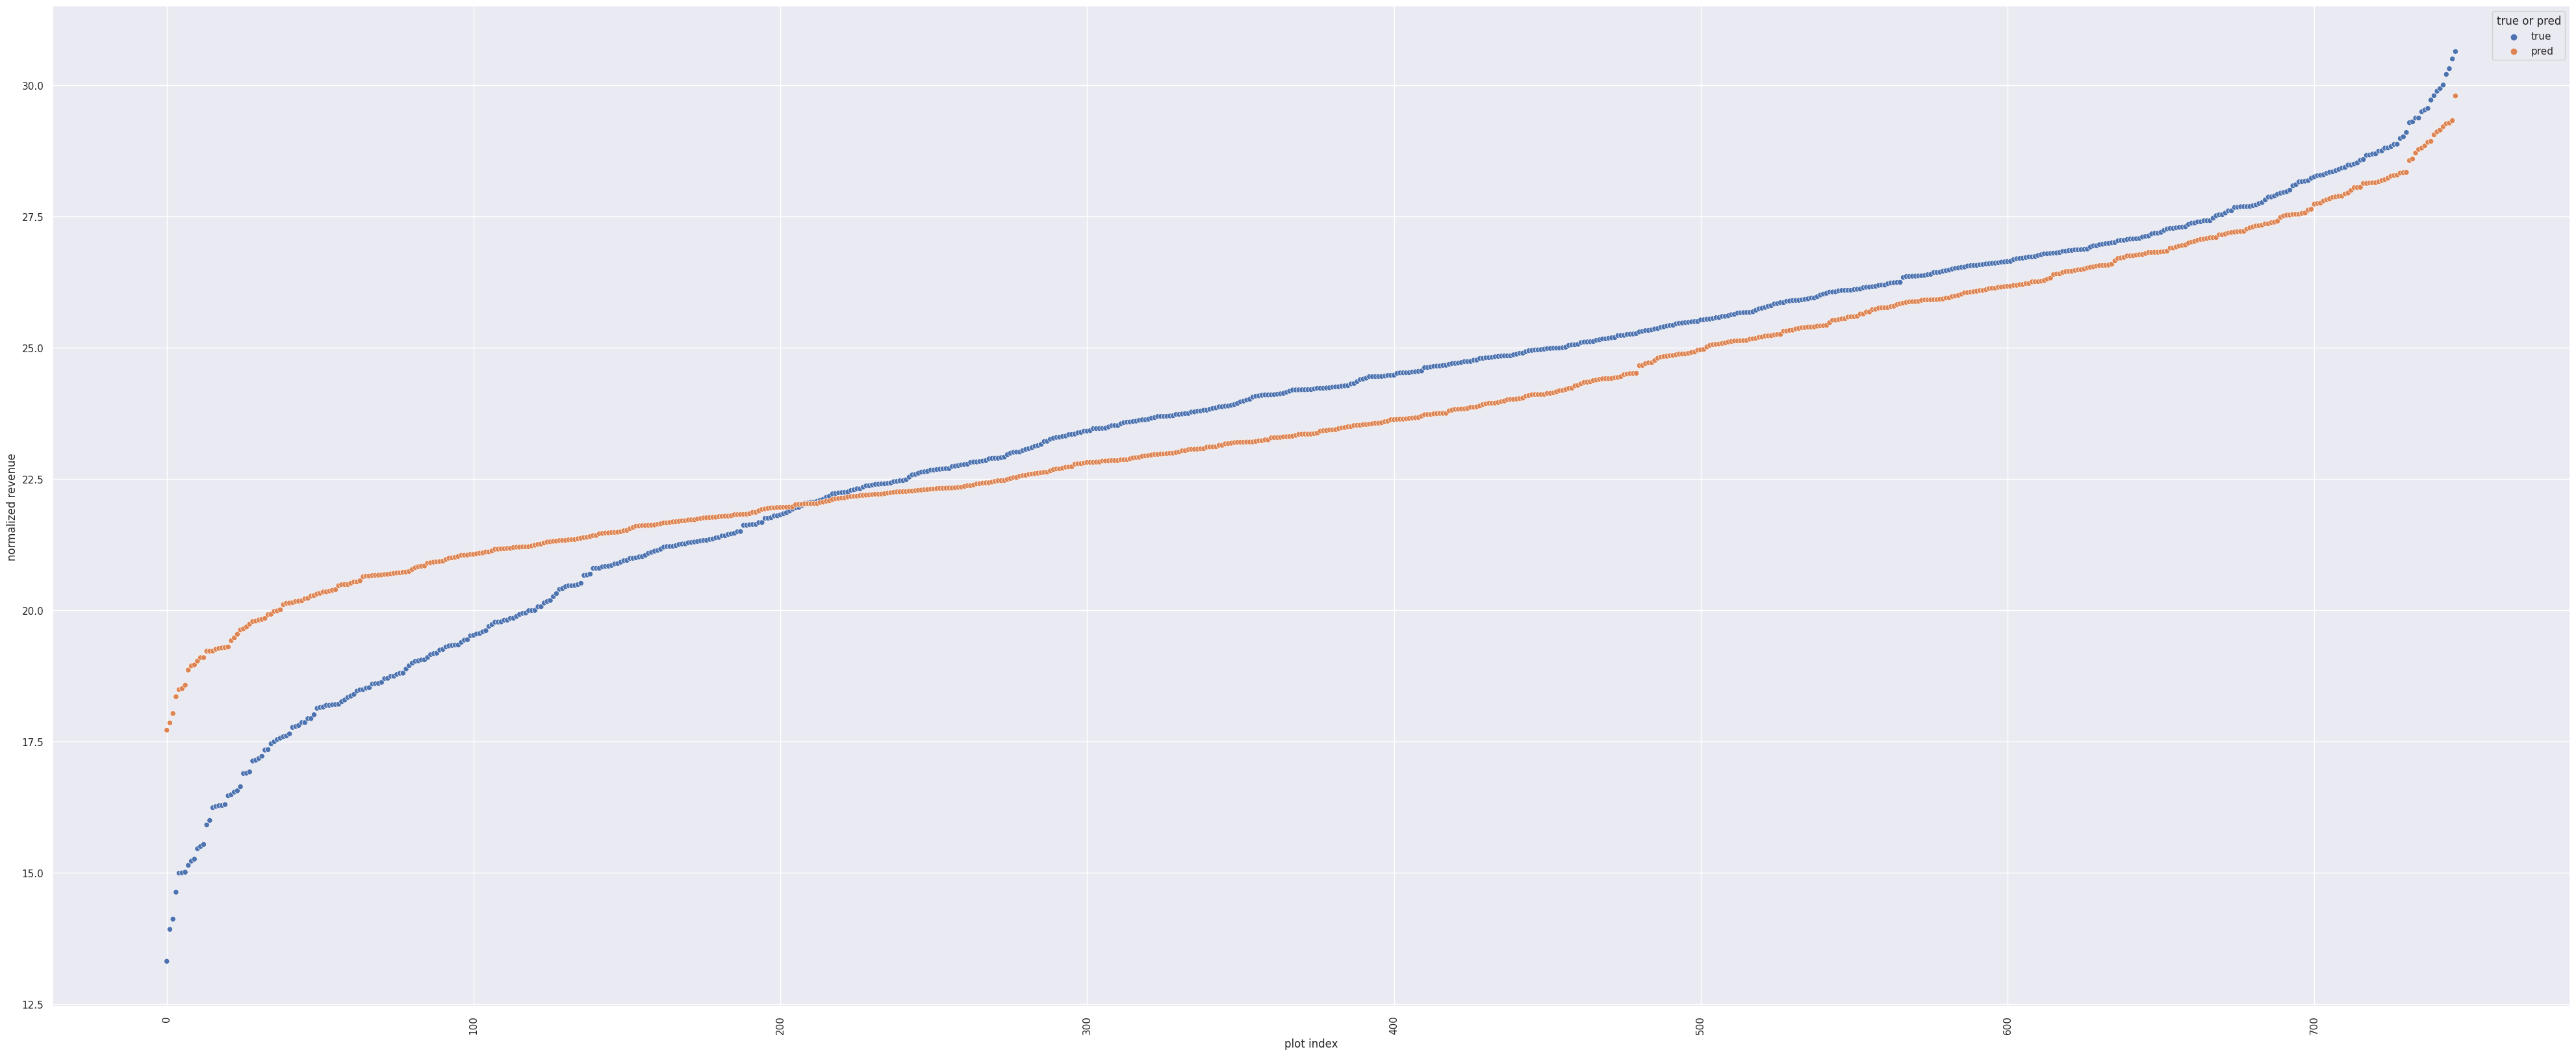

In [14]:
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import numpy as np

RFR_pred_data = pd.DataFrame({'normalized revenue': np.hstack((y_validation, RFR_best_validation_prediction)), 'true or pred': np.hstack((["true"]*len(y_validation) , ["pred"]*len(RFR_best_validation_prediction)))})
RFR_pred_data.sort_values(by=['normalized revenue'], ascending = True, inplace = True)
RFR_pred_data_T = RFR_pred_data[RFR_pred_data["true or pred"] == "true"]
RFR_pred_data_T.insert(0, "plot index", list(range(len(y_validation))))
RFR_pred_data_P = RFR_pred_data[RFR_pred_data["true or pred"] == "pred"]
RFR_pred_data_P.insert(0, "plot index", list(range(len(y_validation))))
RFR_plot_data = pd.concat([RFR_pred_data_T, RFR_pred_data_P])

sns.set(rc={'figure.figsize':(50,20)})
sns.scatterplot(data=RFR_plot_data,
                x="plot index",
                y="normalized revenue",
                hue="true or pred")
plt.xticks(rotation=90);

## Multi Layer Perceptron

In [13]:
try:
    import pickle
    MLP_grid = pickle.load(open('MLP_grid.pickle', 'rb'))
    print("tuned hpyerparameters :(best parameters) ", MLP_grid.best_params_)
    print("Multi Layer Perceptron score on train:", MLP_grid.best_score_)
    MLP_best = MLP_grid.best_estimator_
except:
    import warnings
    warnings.filterwarnings("ignore")
    from sklearn.model_selection import GridSearchCV
    from sklearn.neural_network import MLPClassifier

    grid = {
            "hidden_layer_sizes": [(50), (100), (50, 50), (100, 100)],
            "activation": ["logistic", "tanh", "relu"],
            "solver": ["lbfgs", "sgd", "adam"],
            "momentum": [0.6, 0.9],
            "batch_size": [200, 300, 400],
            "learning_rate": ["constant", "invscaling", "adaptive"],
            "learning_rate_init": [0.001, 0.005, 0.01],
            "power_t": [2/3, 1/2, 1/3],
            "max_iter": [200, 300, 400],
            }

    MLP = MLPClassifier(random_state=SEED, shuffle=True, verbose=1, early_stopping=True)

    MLP_grid = GridSearchCV(MLP, grid, refit = True, n_jobs=-1, cv=10)
    MLP_grid.fit(X_train, y_train)
    print("tuned hpyerparameters :(best parameters) ", MLP_grid.best_params_)
    print("RandomForestRegressor score on train:", MLP_grid.best_score_)
    MLP_best = MLP_grid.best_estimator_

    import pickle
    pickle.dump(MLP_grid, open('MLP_grid.pickle', 'wb'))

exception calling callback for <Future at 0x7f323c305610 state=finished returned list>
Traceback (most recent call last):
  File "/home/meric/anaconda3/envs/470env2/lib/python3.8/site-packages/joblib/externals/loky/_base.py", line 26, in _invoke_callbacks
    callback(self)
  File "/home/meric/anaconda3/envs/470env2/lib/python3.8/site-packages/joblib/parallel.py", line 385, in __call__
    self.parallel.dispatch_next()
  File "/home/meric/anaconda3/envs/470env2/lib/python3.8/site-packages/joblib/parallel.py", line 834, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/home/meric/anaconda3/envs/470env2/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/meric/anaconda3/envs/470env2/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/home/meric/anaconda3/envs/470env2/lib/python3.8/site-packages/jobli

KeyboardInterrupt: 

exception calling callback for <Future at 0x7f32227a1c10 state=finished raised BrokenProcessPool>
Traceback (most recent call last):
  File "/home/meric/anaconda3/envs/470env2/lib/python3.8/site-packages/joblib/externals/loky/_base.py", line 26, in _invoke_callbacks
    callback(self)
  File "/home/meric/anaconda3/envs/470env2/lib/python3.8/site-packages/joblib/parallel.py", line 385, in __call__
    self.parallel.dispatch_next()
  File "/home/meric/anaconda3/envs/470env2/lib/python3.8/site-packages/joblib/parallel.py", line 834, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/home/meric/anaconda3/envs/470env2/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/meric/anaconda3/envs/470env2/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/home/meric/anaconda3/envs/470env2/lib/python3.8/site-pac

## Neural network

In [2]:
keras tuner
xgboost

SyntaxError: invalid syntax (2479618849.py, line 1)